### Setup

In [1]:
!pip install -Uqq diffusers transformers datasets accelerate ftfy bitsandbytes wandb

### Dataset

In [1]:
import torch
from torch import Tensor
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from torch.utils.data import Dataset, DataLoader
from typing import List, Dict
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from transformers import CLIPFeatureExtractor, CLIPTextModel
from argparse import Namespace
import random
from tqdm.auto import tqdm
import math
import wandb
import os
import itertools

device = 'cuda' if torch.cuda.is_available() else 'cpu'
wandb.login()

wandb: Currently logged in as: matt24. Use `wandb login --relogin` to force relogin


True

In [2]:
from datasets import load_dataset

# dataset_name = 'lewtun/corgi'
dataset_name = 'matteopilotto/porkypig'
dataset = load_dataset(dataset_name, split='train')

dataset

Using custom data configuration matteopilotto--porkypig-38bc4f758ad55035
Found cached dataset parquet (/root/.cache/huggingface/datasets/matteopilotto___parquet/matteopilotto--porkypig-38bc4f758ad55035/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image'],
    num_rows: 11
})

In [3]:
from PIL import Image

def image_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    
    return grid

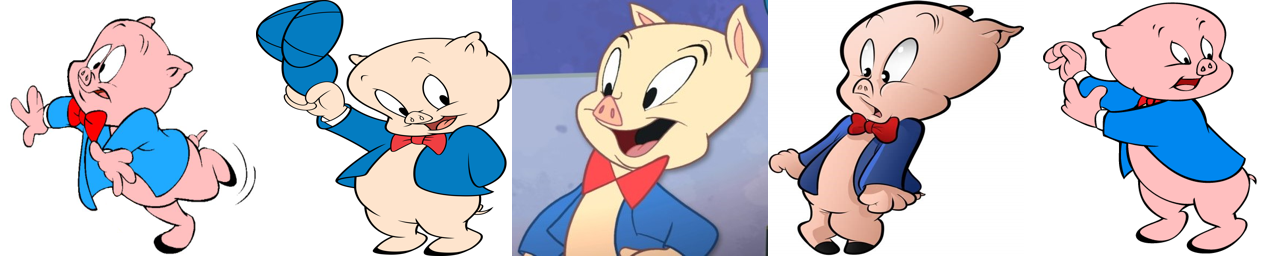

In [4]:
image_grid([image.resize((256, 256)) for image in dataset['image']], rows=1, cols=5)

In [5]:
# unique_id = 'ccorgi'
# class_type = 'dog'
# instance_prompt = f'a photo of {unique_id} {class_type}'
# print(instance_prompt)

In [6]:
unique_id = 'pplt' # meaning "pork pig looney tunes"
class_type = 'pig'
instance_prompt = f'a photo of {unique_id} {class_type}'
print(instance_prompt)

a photo of pplt pig


In [7]:
from torch.utils.data import Dataset
from torchvision import transforms

class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, img_size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        # self.img_size = img_size
        
        self.img_transforms = transforms.Compose([
            transforms.Resize(img_size),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]['image']
        example['instance_image'] = self.img_transforms(image)
        example['instance_input_ids'] = self.tokenizer(
                                            self.instance_prompt,
                                            padding='do_not_pad',
                                            truncation=True,
                                            max_length=self.tokenizer.model_max_length
                                        ).input_ids
        
        return example

In [8]:
from transformers import CLIPTokenizer

sd_ckpt = 'CompVis/stable-diffusion-v1-4'
tokenizer = CLIPTokenizer.from_pretrained(sd_ckpt, subfolder='tokenizer')

train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer, img_size=512)

### Dataloader

In [9]:
def collate_fn(examples: List[Dict[str, Tensor]]) -> Dict[str, List[Tensor]]:
    input_ids = [example['instance_input_ids'] for example in examples]
    pixel_values = [example['instance_image'] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    
    input_ids = tokenizer.pad({'input_ids': input_ids}, padding=True, return_tensors='pt').input_ids
    
    batch = {'input_ids': input_ids,
             'pixel_values': pixel_values}
    
    return batch

In [10]:
examples = [train_dataset[i] for i in range(len(train_dataset))]
batch = collate_fn(examples)
# batch

In [11]:
text_encoder = CLIPTextModel.from_pretrained(sd_ckpt, subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained(sd_ckpt, subfolder='vae')
unet = UNet2DConditionModel.from_pretrained(sd_ckpt, subfolder='unet')
feature_extractor = CLIPFeatureExtractor.from_pretrained('openai/clip-vit-base-patch32')

In [12]:
batch_size = 1

train_dl = DataLoader(dataset=train_dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      collate_fn=collate_fn)

In [13]:
batch = next(iter(train_dl))
# batch

### Fine-tuning with Accelerate

In [14]:
lr = 2e-6
max_train_steps = 550
sample_prompts = [
    f'an illustration of {unique_id} {class_type} wearing a Santa hat in a snowy forest',
    f'a photograph of {unique_id} {class_type} reading a book on the beach',
    f'a sketch of {unique_id} {class_type} painting a mountain landscape',
    f'a drawing of {unique_id} {class_type} wearing a Spider-man costume in the style of Marvel comics'
]

from argparse import Namespace

args = Namespace(
    pretrained_model_name_or_path=sd_ckpt,
    resolution=512, # Reduce this if you want to save some memory
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=lr,
    max_train_steps=max_train_steps,
    train_batch_size=1,
    gradient_accumulation_steps=1, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # set this to True to lower the memory usage.
    use_8bit_adam=True,  # use 8bit optimizer from bitsandbytes
    seed=2077,
    eval_batch_size=1,
    output_dir="my-dreambooth", # where to save the pipeline
    project_name='dreambooth-demo-2',
    guidance_scale=7,
    # sample_prompt=f"a photo of {unique_id} {class_type} with a Santa hat in the snowny forest.",
    train_text_encoder=True,
    eval_samples_every_epochs=10,
    sample_prompts=sample_prompts
)

In [15]:
def train_fn(text_encoder, vae, unet):
    
    # init Accelerator
    accelerator = Accelerator(gradient_accumulation_steps=args.gradient_accumulation_steps,
                              log_with="wandb",
                              logging_dir=os.path.join(args.output_dir, 'logs'))
    
    # set seed
    set_seed(args.seed)
    
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)
    text_encoder.to(accelerator.device)
    
    vae.requires_grad_(False)
    vae.to(accelerator.device)
    
    feature_extractor = CLIPFeatureExtractor.from_pretrained('openai/clip-vit-base-patch32')
    
    # enable gradient checkpointing
    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        
    # optimizer
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW
    
    # ref. itertools.chain: https://discuss.pytorch.org/t/giving-multiple-parameters-in-optimizer/869/8?u=matteo_pilotto
    if args.train_text_encoder:
        params_to_optimize = itertools.chain(unet.parameters(), text_encoder.parameters())
    else:
        params_to_optimize = unet.parameters()
        
    optimizer = optimizer_class(params=params_to_optimize, lr=args.learning_rate)
    
    # init noise scheduler
    noise_scheduler = DDPMScheduler(beta_start=8.5e-4,
                                    beta_end=1.2e-2,
                                    beta_schedule='scaled_linear',
                                    num_train_timesteps=1000)
    
    # init inference scheduler
    inference_scheduler = PNDMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        skip_prk_steps=True,
        steps_offset=1,
    )
    
    # define train dataloader
    train_dl = DataLoader(dataset=args.train_dataset,
                          batch_size=args.train_batch_size,
                          collate_fn=collate_fn,
                          shuffle=True)
    
    # calculate the total number of epochs based on the number of training steps adjusted to grad. acc. steps
    train_steps_per_epoch = math.ceil(len(train_dl) / args.gradient_accumulation_steps)
    train_epochs = math.ceil(args.max_train_steps / train_steps_per_epoch)
    
    # total batch size
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps
    
    # prepare unet, optimizer and train dataloader to work with Accelerate
    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dl = accelerator.prepare(unet, text_encoder, optimizer, train_dl)
    else:
        unet, optimizer, train_dl = accelerator.prepare(unet, optimizer, train_dl)
    
    # init tracker
    if accelerator.is_main_process:
        accelerator.init_trackers(project_name=args.project_name, config=args)
    
    # init WANDB table
    log_prompts = [prompt for prompt in args.sample_prompts for i in range(args.eval_batch_size)]
    log_table = wandb.Table(columns=['prompt'])
    for p in log_prompts:
        log_table.add_data(p)
    
    # init progress bar
    progress_bar = tqdm(range(args.max_train_steps), disable=(not accelerator.is_local_main_process))
    progress_bar.set_description('Steps')
    global_step = 0
    
    # training loop
    for epoch in range(train_epochs):
        unet.train()
        
        if args.train_text_encoder:
            text_encoder.train()
            
        for i, batch in enumerate(train_dl):
            with accelerator.accumulate(unet):
                # compute latents (i.e. image embeddings)
                with torch.inference_mode():
                    latents = vae.encode(batch['pixel_values']).latent_dist.sample()
                    latents *= 0.18215

                # init noise
                noise = torch.randn_like(latents).to(accelerator.device)

                # compute random timesteps
                batch_size = latents.shape[0]
                num_train_ts = noise_scheduler.num_train_timesteps
                timesteps = torch.tensor([random.randint(0, num_train_ts-1) for _ in range(batch_size)])
                timesteps = timesteps.to(accelerator.device)

                # add noise to latents
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # compute text embeddings
                # with torch.inference_mode():
                #     text_embeds = text_encoder(batch['input_ids'])[0]
                # text_embeds = torch.clone(text_embeds)
                text_embeds = text_encoder(batch['input_ids'])[0]
                

                # predict noise (forward pass)
                noise_pred = unet(noisy_latents, timesteps, text_embeds).sample

                # compute loss
                loss = F.mse_loss(noise_pred, noise, reduction='none').mean([1, 2, 3]).mean()

                # backward pass
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    if args.train_text_encoder:
                        params_to_clip = itertools.chain(unet.parameters(), text_encoder.parameters())
                    else:
                        params_to_clip = unet.parameters()
                        
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)

                # optimizer step & zero grad
                optimizer.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item(),
                    'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                    'step': global_step,
                    'epoch': epoch+1}
            
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            if global_step >= args.max_train_steps:
                break
                
        accelerator.wait_for_everyone()
        
        # Generate sample images for visual inspection
        if accelerator.is_main_process:
            if (epoch+1) % args.eval_samples_every_epochs == 0:
                print(f'[INFO] Generating samples for Epoch {epoch+1}...')
                
                pipeline = StableDiffusionPipeline(
                    text_encoder=accelerator.unwrap_model(text_encoder),
                    vae=vae,
                    unet=accelerator.unwrap_model(unet),
                    tokenizer=tokenizer,
                    scheduler=inference_scheduler,
                    safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
                    feature_extractor=feature_extractor,
                ).to(accelerator.device)
                
                sample_images = []
                for sample_prompt in sample_prompts:
                    generator = torch.Generator(device=pipeline.device).manual_seed(args.seed)
                
                    # run pipeline in inference (sample random noise and denoise)
                    for _ in range(args.eval_batch_size):
                        print(f'[INFO] generating image for "{sample_prompt}" prompt...')
                        images = pipeline(
                            prompt=sample_prompt,
                            guidance_scale=args.guidance_scale,
                            generator=generator).images
                        sample_images.extend(images)

                # accelerator.trackers[0].log({"examples": [wandb.Image(image) for image in sample_images]})
                log_images = [wandb.Image(image) for image in sample_images]
                log_table.add_column(name=f'epoch_{epoch+1}', data=log_images)
                accelerator.trackers[0].log({'examples': log_table})
    
    if accelerator.is_main_process:
        print(f'[INFO] Loading pipeline and saving it to {args.output_dir}')
        
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=inference_scheduler,
            feature_extractor=feature_extractor,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained('CompVis/stable-diffusion-safety-checker')
        )
        
        pipeline.save_pretrained(args.output_dir)

    accelerator.end_training()

In [16]:
# wandb.finish()

In [ ]:
from accelerate import notebook_launcher

# init models
text_encoder = CLIPTextModel.from_pretrained(sd_ckpt, subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained(sd_ckpt, subfolder='vae')
unet = UNet2DConditionModel.from_pretrained(sd_ckpt, subfolder='unet')
feature_extractor = CLIPFeatureExtractor.from_pretrained('openai/clip-vit-base-patch32')

num_of_gpus = 1
notebook_launcher(train_fn, args=(text_encoder, vae, unet), num_processes=num_of_gpus)

Launching training on one GPU.


  0%|          | 0/550 [00:00<?, ?it/s]

[INFO] Generating samples for Epoch 10...
[INFO] generating image for "an illustration of pplt pig wearing a Santa hat in a snowy forest" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


[INFO] generating image for "a photograph of pplt pig reading a book on the beach" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a sketch of pplt pig painting a mountain landscape" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a drawing of pplt pig wearing a Spider-man costume in the style of Marvel comics" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] Generating samples for Epoch 20...
[INFO] generating image for "an illustration of pplt pig wearing a Santa hat in a snowy forest" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a photograph of pplt pig reading a book on the beach" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a sketch of pplt pig painting a mountain landscape" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a drawing of pplt pig wearing a Spider-man costume in the style of Marvel comics" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] Generating samples for Epoch 30...
[INFO] generating image for "an illustration of pplt pig wearing a Santa hat in a snowy forest" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a photograph of pplt pig reading a book on the beach" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a sketch of pplt pig painting a mountain landscape" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a drawing of pplt pig wearing a Spider-man costume in the style of Marvel comics" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] Generating samples for Epoch 40...
[INFO] generating image for "an illustration of pplt pig wearing a Santa hat in a snowy forest" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a photograph of pplt pig reading a book on the beach" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a sketch of pplt pig painting a mountain landscape" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a drawing of pplt pig wearing a Spider-man costume in the style of Marvel comics" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] Generating samples for Epoch 50...
[INFO] generating image for "an illustration of pplt pig wearing a Santa hat in a snowy forest" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a photograph of pplt pig reading a book on the beach" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a sketch of pplt pig painting a mountain landscape" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] generating image for "a drawing of pplt pig wearing a Spider-man costume in the style of Marvel comics" prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] Loading pipeline and saving it to my-dreambooth


### Inference

In [37]:
pipeline = StableDiffusionPipeline.from_pretrained(args.output_dir, torch_dtype=torch.float16).to(device)

In [38]:
prompt = f"a photo of {unique_id} {class_type} with a Santa hat."
negative_prompt = 'low contrast, blurry, low resolution, warped'
guidance_scale = 7

all_images = []
num_cols = 16
generator = torch.Generator(device=device).manual_seed(args.seed)

for _ in range(num_cols):
    images = pipeline(prompt,
                      # negative_prompt=negative_prompt,
                      guidance_scale=guidance_scale,
                      generator=generator).images
    all_images.extend(images)

# image_grid(all_images, 1, num_cols)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

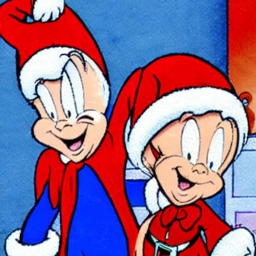

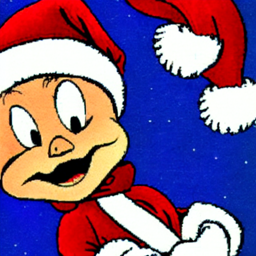

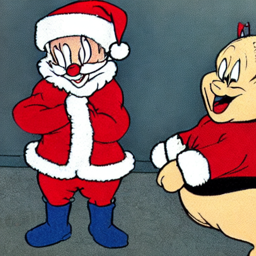

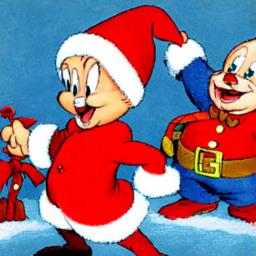

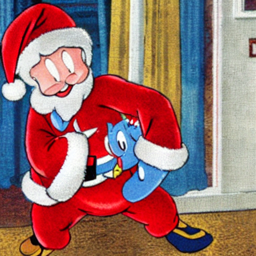

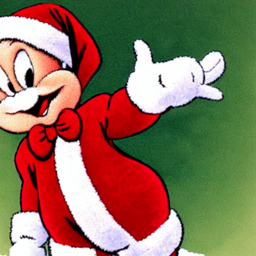

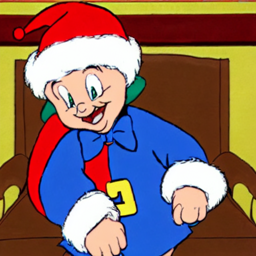

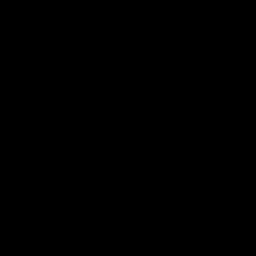

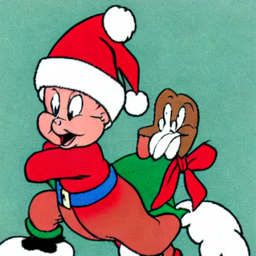

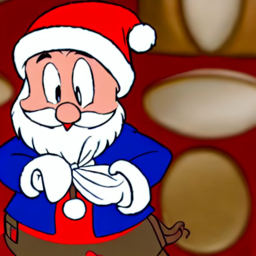

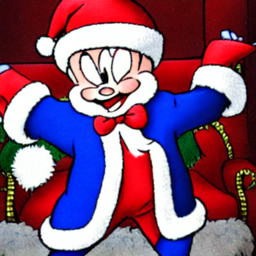

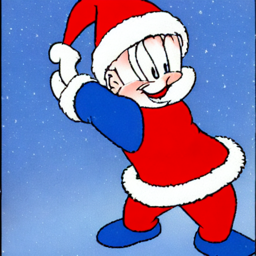

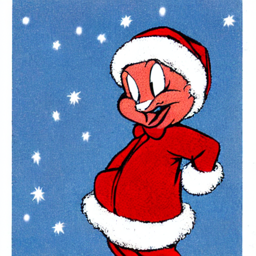

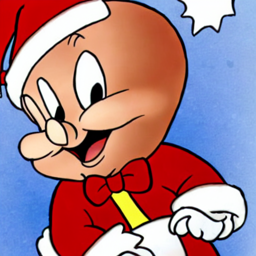

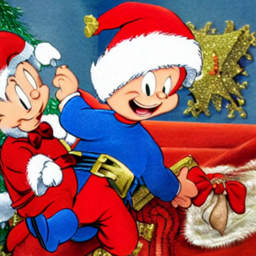

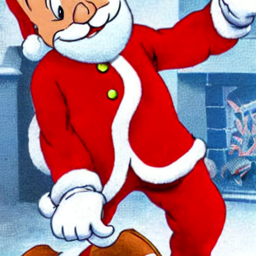

In [39]:
for image in all_images:
    display(image.resize((256, 256)))